### Table of Contents
#### Introduction to Quantum Harmonic Oscillator
#### High Fidelity Solver
##### - Finite Difference Method
##### - Comparison to Exact
#### Reduced Basic Method
##### - M0, M1, and N Matrices
##### - Compare Solutions 

### Introduction to Quantum Harmonic Oscillator
The quantum harmomic oscillator is a widely studied model in quantum mechanics that describes the behavior of a particle undergoing harmonic motion. In classical physics, this would be simple harmonic motion. However, quantum mechanics complicates this behavior. The function takes in a parameter alpha, which is a constant. 

In the context of the Schrödinger Equation, the quantum harmonic oscillator is a formulation of it. It can be represented mathematically in the equation below:

$$ (\frac{d^2}{dx^2} + \alpha x^2 - \lambda )\phi(x) = 0 $$

Here are the libraries we will use in the following code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy as sci
from scipy import optimize
import time as ti
from scipy import linalg
import random

Because the quantum harmonic oscillator is a relatively simple quantum system, analytical solutions for the system are known. To test the efficiency of our code, we can check against the analytical solutions to determine the exact error. 

In [3]:
def getExactLambda(alpha):
  n = 0
  return 2 * (.5 + n) * np.sqrt(alpha / 1**2)

### High Fidelity Solver
#### Finite Difference Method
Finite difference method discretizes the space and divides the wavefunction of the particle into some amount of points. We can use this to simplify the wavefunction and treat it as a collection of points. This method is meant to find the high fidelity solution to the system. We do not need to use the finite difference method as our high fidelity solver, but it works pretty well

Here are the libraries we will use in the following code

The FDM class is used for solving the system with the finite difference method. It involves creating the kinetic energy term, the potential energy term, adding them together, and solving for the eigenvalues and eigenvectors. Take a look at the following code and the corresponding comments. 

In [4]:
class FDM:
    
    def __init__(self, h, timingInt):
        """
        The two parameters are h and the timing integer. 
        The number of points on the matrix is decided by h. A smaller h value means more points, but also more time to run. 
        The second parameter is the timing integer. The purpose of this value will become clearer in the timing function. 
        """
        self.h = h
        self.timingInt = timingInt
        self.x_max = 10.0
        self.x = np.arange(-self.x_max, self.x_max + h, h)
        
    def xShape(self):
        # This is used for creating the m matrix later on, but doesn't play much of a role in finding the solutions. 
        return self.x, self.x.shape[0]

    def hf_second_derivative(self):
        # We create the second derivative (kinetic energy) matrix here. 
        N = len(self.x)
        dx = self.x[1] - self.x[0]

        # Generate the matrix for the second derivative using a five-point stencil
        main_diag = np.ones(N) * (-5.0 / 2 / dx**2)
        off_diag = np.ones(N - 1) * 4 / 3 / dx**2
        off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))

        D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(
            off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)

        return D2

    def hf_potential(self):
        # We create the potential energy matrix here
        return np.diag(self.x**2)

    def HO_creator(self, alpha):
        # HO_creator puts the matrices together and accounts for some value of alpha 
        D2Mat = self.hf_second_derivative()
        vpot = self.hf_potential()
        return -D2Mat + alpha * vpot

    def timing(self, H):
        """
        In the timing function, we solve the solution many times and get the average of the times. 
        This helps to boost the accuracy of the time value. The timingInt value determines how many times to collect. 
        """
        solveTime = []
        for i in range(self.timingInt):
            time0 = time.time()
            evals, evects = np.linalg.eigh(H)
            time1 = time.time()
            solveTime.append(time1 - time0)
        avg = sum(solveTime) / len(solveTime)
        return avg

    def HO_solver(self, alpha):
        # We use the numpy linalg.eigh function to solve for the eigenvalues and eigenvectors of the matrix. 
        H = self.HO_creator(alpha)
        evals, evects = np.linalg.eigh(H)
        solveTime = self.timing(H)
        evects= evects.T
        m_val = evects[0] / np.linalg.norm(evects[0])*np.sign(evects[0][  int(len(self.x)/2) ])
        return evals, evects, solveTime, m_val


The following sections of code are used for a graphical representation of the high fidelity solution. Below, we loop through different h values, and alphas to determine the time and error of solving with the fininite difference method. 

In [5]:
def get_alphas(usage):
    # Set a seed for reproducibility
    if usage.lower() == "test":
        np.random.seed(42)
        N_test = 20
        lower_bound_int = 0.5
        upper_bound_int = 30
        random_integers = np.random.randint(lower_bound_int, upper_bound_int + 1, N_test)
    elif usage.lower() == "train":
        np.random.seed(98)
        N_test = 30
        lower_bound_int = 0.5
        upper_bound_int = 30
        random_integers = np.random.randint(lower_bound_int, upper_bound_int + 1, N_test)
    return random_integers

In [6]:
def HF_solutions(h):
    alphas = get_alphas("train")
    
    timingInt = 10
    tempTimes = []
    tempErrors = []
    fdm_instance = FDM(h, timingInt)

    for i in range(len(alphas)):
        alpha = alphas[i]
        # We used the classes' function HO_solver() to solve the equation for different alpha values
        evals, evects, t1me, m_val = fdm_instance.HO_solver(alpha)

        # We use our exact solution to compare to the calculated eigenvalue
        exactEigenvalue = getExactLambda(alpha)
        err = abs((evals[0] - exactEigenvalue) / exactEigenvalue)
        
        tempTimes.append(t1me)
        tempErrors.append(err)
    return tempTimes, tempErrors

Please be aware that this next section of code takes a while to run! This is why RBM is so important!

In [7]:
h_list = [.1, .05, .03, .025]
timingInt = 10
# htimes and herrors will store the times and errors for the high fidelity solution
htimes = []
herrors = []

maxErr = []
maxTimes = []
minErr = []
minTimes = []
# We want to test different h values to observe a change in accuracy as the number of points increases. 
for h in h_list:
    # We only need one instance of the class, but we will solve for different alpha values
    times, errors = HF_solutions(h)

    # We need these values for the limits on the graph
    maxErr.append(max(errors))
    maxTimes.append(max(times))
    minErr.append(min(errors))
    minTimes.append(min(times))

    htimes.append(times)
    herrors.append(errors)


To see the wavefunctions run the following code. The m matrix will be very important for the RBM solution. The more alphas, the more functions graphed. 

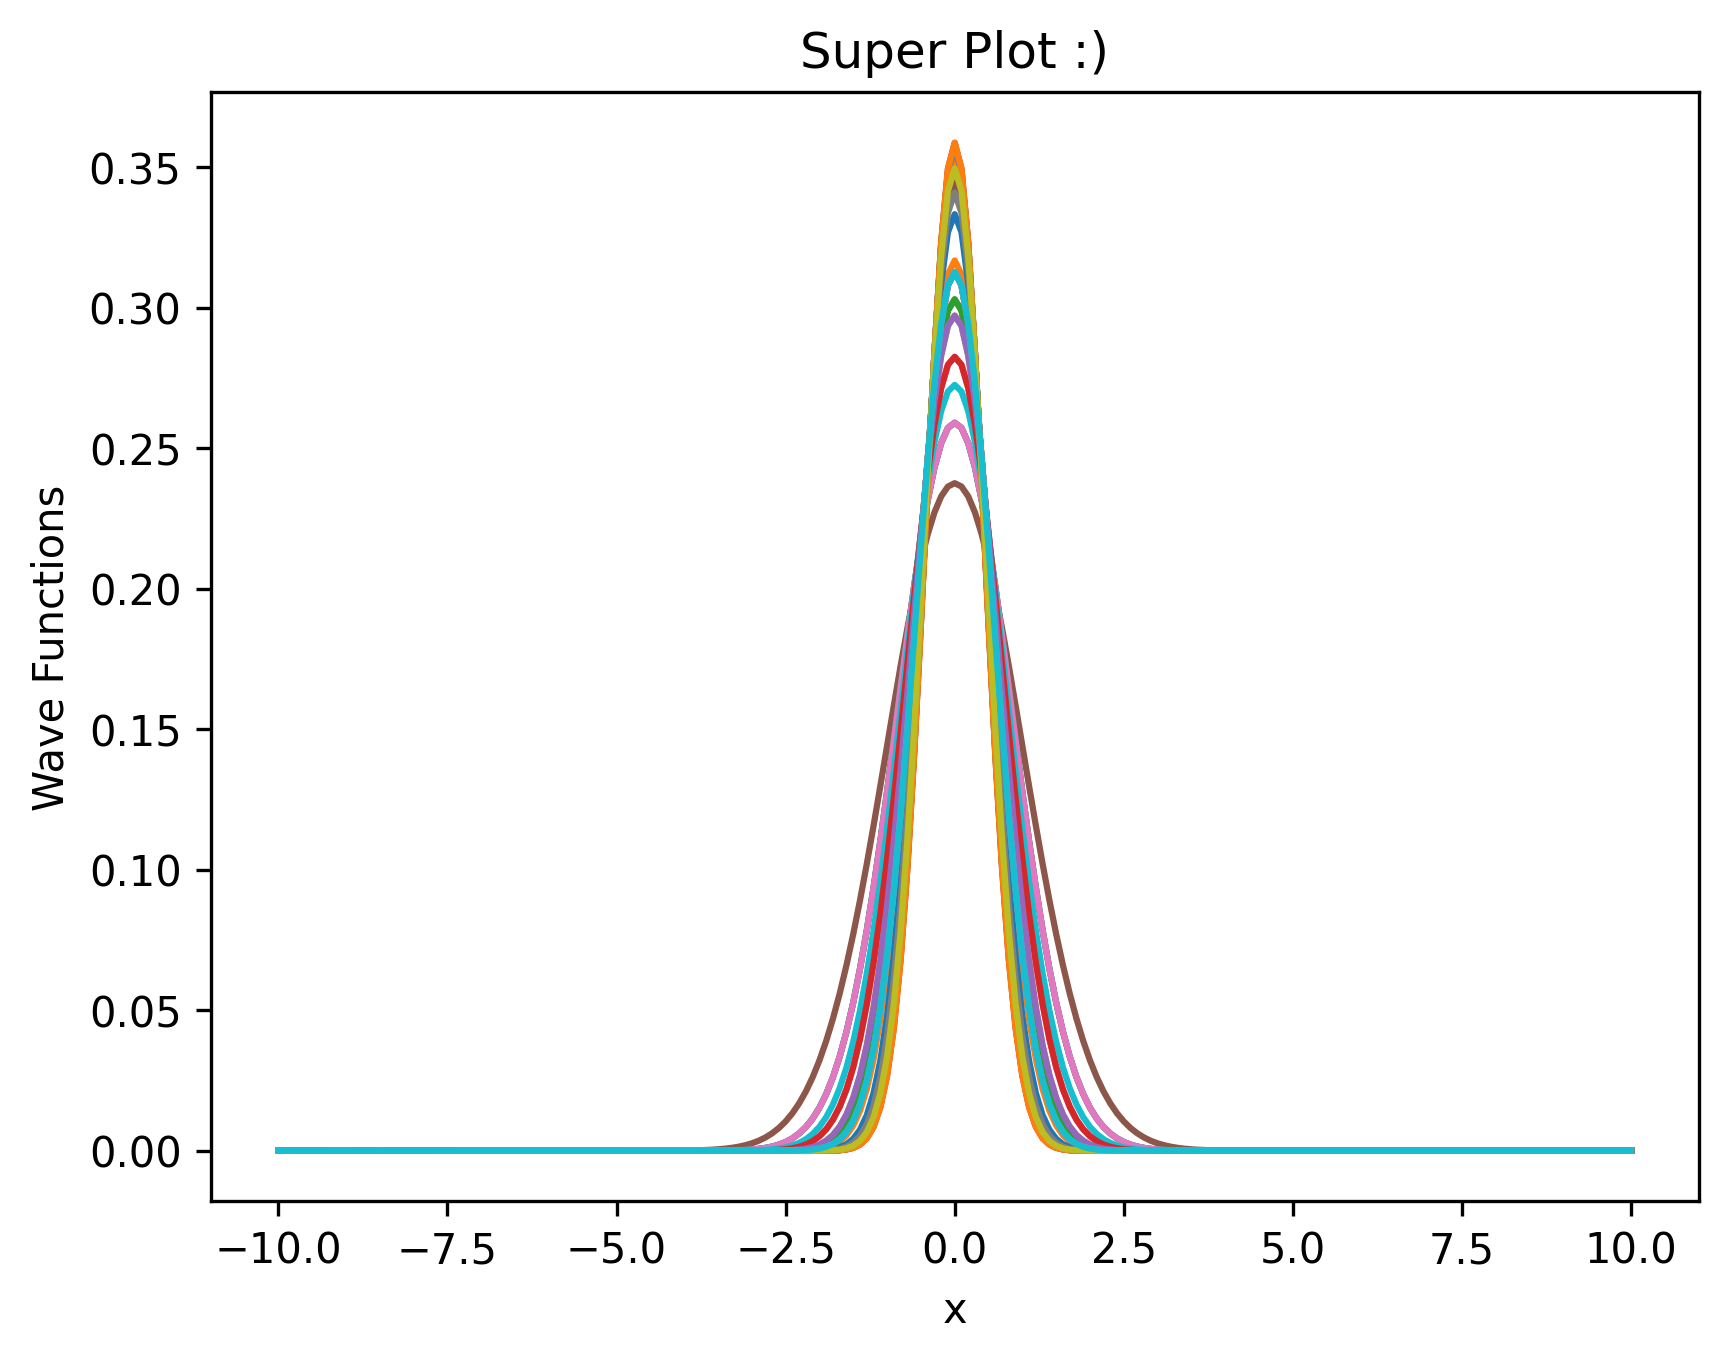

In [8]:
# h is arbitrarily chosen, but it takes longer to run for a smaller value
h = 10**-1
fdm_instance = FDM(h, timingInt)
x, x_shape = fdm_instance.xShape()
alphas = get_alphas("train")
# The different solutions are stored in the m matrix
m = np.zeros((len(alphas), x_shape))
for i in range(len(alphas)):
    alpha = alphas[i]
    evals, evects, t1me, m_val = fdm_instance.HO_solver(alpha)
    m[i] = m_val

# We graph the wavefunctions below
    
fig, ax = plt.subplots(dpi=300)

for i in range(len(m)):
    ax.plot(x, m[i])

ax.set_title("Super Plot :)")
ax.set_xlabel("x")
ax.set_ylabel("Wave Functions")

plt.show()


#### Comparison to Exact
In the code below, we will graph the data we collected for the times and errors of solving with the high fidelity solution. 

/tmp/ipykernel_2932/1923027263.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  catAx.set(xscale='log',yscale='log',
/tmp/ipykernel_2932/1923027263.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  catAx.set(xscale='log',yscale='log',


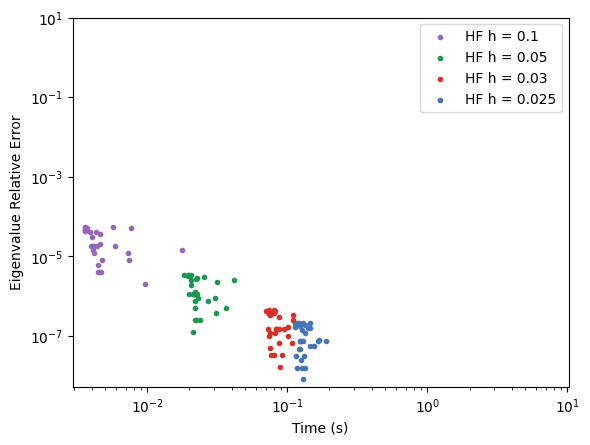

In [9]:
hminT = min(minTimes) - 10
hmaxT = max(maxTimes) + 10
hminEr = min(minErr) - 10
hmaxEr = max(maxErr) + 10 

# Thank you ChatGPT for the following colors!
hcolors = [
    "#9467bd",  # Purple
    "#1a9850",  # Emerald Green
    "#d73027",  # Crimson Red
    "#4575b4",  # Steel Blue
    "#fdae61",  # Apricot
    "#313695"   # Midnight Blue
]

catFig, catAx = plt.subplots()

for i in range(len(h_list)):
    label = "HF h = " + str(h_list[i])
    catAx.scatter(htimes[i],herrors[i],color=hcolors[i],
               marker='.',label=label)

catAx.set(xscale='log',yscale='log',
           xlabel='Time (s)',ylabel='Eigenvalue Relative Error',
           xlim=(hminT, hmaxT),ylim=(hminEr,hmaxEr))

plt.legend()
plt.show()

### Reduced Basis Method
FDM is super cool, and it's great that we were able to do that. But, what if we can make it faster? In a simple system like this, speed isn't the biggest deal in the world. However, in more complicated systems, time becomes much more important, and speeding up the system is neccesary. The purpose of this chapter and overall book is to demonstrate a way of formulating the equation such that the time to solve the equation is reduced.

#### M0, M1, and N Matrices

We already have worked with the system represented by the following function:

$$ (\frac{d^2}{dx^2} + \alpha x^2 - \lambda )\phi(x) = 0 $$

However, we can put forth a reformulation of the math.

Because we are solving an eigenvalue problem, we can arrive at a set of different-looking equations, using the same set of judges $\{\psi_i(x)\}_{i=1}^n$ as before. We can simply plug $\hat{\phi}_{\alpha_k}$ into the Schrodinger equation and project both sides onto the judges, writing

\begin{align}
\sum_{i=1}^na_i\langle \psi_j|H_{\alpha_k}|\phi_i\rangle=\lambda\sum_{i=1}^na_i\langle\psi_j|\phi_i\rangle.
\end{align}

Define now two matrices:

\begin{align}
M_{ij}(\alpha)\equiv \langle\psi_j|H_\alpha|\phi_i\rangle,\quad N_{ij}\equiv\langle\psi_j|\phi_i\rangle.
\end{align}

These are both $n\times n$ matrices, and we now have a generalized eigenvalue problem for $\vec{a}$:

\begin{align}
M(\alpha)\vec{a}=\lambda N\vec{a}.
\end{align}

Situationally, this may be quicker to solve than finding the roots of the nonlinear system that results from the "traditional" RBM approach.

As with traditional RBM approaches, this is only helpful if we can evaluate $M(\alpha)$ quickly for different $\alpha$ values. For the HO, this is not too hard: we can write

\begin{align}
\langle\psi_j|H_\alpha|\phi_i\rangle=\langle\psi_j|T|\phi_i\rangle+\alpha\langle \psi_j|x^2|\phi_i\rangle\equiv M_{ij}^{(0)}+\alpha M_{ij}^{(1)}.
\end{align}

Our eigenvalue equation is then

\begin{align}
[M^{(0)}+\alpha M^{(1)}]\vec{a}=\lambda N\vec{a},
\end{align}

and all of $M^{(0)},M^{(1)}$ and $N$ can be precomputed.
 
A code implementation is given below.


In [14]:
class RBM:
    def __init__(self, h, m, components):
        # Since we create the kinetic and potential energy terms, we use the h value
        self.m = m
        self.h = h
        self.components = components
        self.psi = np.array(self.getReducedBasis())
        self.phi = self.psi
        self.x_max = 10.0
        self.x = np.arange(-self.x_max, self.x_max + h, h)
        self.d2 = self.second_derivative_matrix()
        self.pot = self.potential_matrix()
        self.compvec = np.zeros(components)
        self.array = self.create_array()
        self.M_0 = np.array(self.array)
        self.M_1 = np.array(self.array)
        self.N = np.array(self.array)
        for i in range(self.components):
            for j in range(i, self.components):
                self.M_0[i][j] = self.phi[i] @ self.d2 @ self.psi[j]
                self.M_0[j][i] = self.M_0[i][j]
                self.M_1[i][j] = self.phi[i] @ self.pot @ self.psi[j]
                self.M_1[j][i] = self.M_1[i][j]
        self.create_N()

    def create_array(self):
        # We use this to create a component x component long matrix
        array = []
        for i in range(self.components):
            array.append(self.compvec)
        return array
    
    def second_derivative_matrix(self):
        N = len(self.x)
        dx = self.h

        # Generate the matrix for the second derivative using a five-point stencil
        main_diag = np.ones(N) * (-205.0 / 72 / dx**2)
        off_diag = np.ones(N - 1) * 8.0 / 5 / dx**2
        off_diag2 = np.ones(N - 2) * (-1 / (5 * dx**2))
        off_diag3 = np.ones(N - 3) * (8 / 315 / dx**2)
        off_diag4 = np.ones(N - 4) * (-1 / 560 / dx**2)

        D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(
      off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2) + np.diag(off_diag3, k = 3) + np.diag(off_diag3, k = -3) + np.diag(off_diag4, k = -4) + np.diag(off_diag4, k = 4)
    
        return -D2

    def potential_matrix(self):
        # We create the potential energy matrix
        return np.diag(self.x**2)

    def getReducedBasis(self):
        # We apply SVD to get the reduced basis based on the number of components
        U, sigma, Vh = np.linalg.svd(self.m)
        reduced_basis = Vh[:self.components]
        return reduced_basis
    
    # Below we create the four matrices that we need, using np.dot to get the dot product between the phi and psi list
    def M0(self, i, j):
        M0 = np.dot(self.psi[j], np.dot(self.d2, self.phi[i]))
        return M0

    def M1(self, i, j):
        M1 = np.dot(self.psi[j], np.dot(self.pot, self.phi[i]))
        return M1
    
    # Note that this function takes in the alpha parameter 
    def create_H_hat(self, alpha):
        H_hat = self.M_0 + alpha*self.M_1
        return H_hat
    
    def create_N(self):
        for i in range(self.components):
            for j in range(i, self.components):
                self.N[i,j] = self.phi[i] @ self.psi[j]
                self.N[j,i] = self.N[i,j]

    # Note that this function takes in the alpha parameter to pass it on to the create_H_hat() function
    def RBM_solve(self, alpha):
        H_hat = self.create_H_hat(alpha)
        #self.create_N()
        #evals, evects = np.linalg.eigvalsh(H_hat)
        evals = np.linalg.eigvalsh(H_hat)
        return evals, evects

#### Compare Solutions 
We now compare the high fidelity solutions to the RBM solutions in terms of time and error. If all goes as planned, the high fidelity solutions should take more time and have a lower error, while the RBM solutions should have higher error and take less time. We will provide a comparison between the calculated eigenvalues and the exact eigenvalue created from our analytical solution. The graph of the solutions includes the number of components for the RBM solutions. 

/tmp/ipykernel_2932/1368384987.py:71: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  catAx.set(xscale='log',yscale='log',
/tmp/ipykernel_2932/1368384987.py:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  catAx.set(xscale='log',yscale='log',


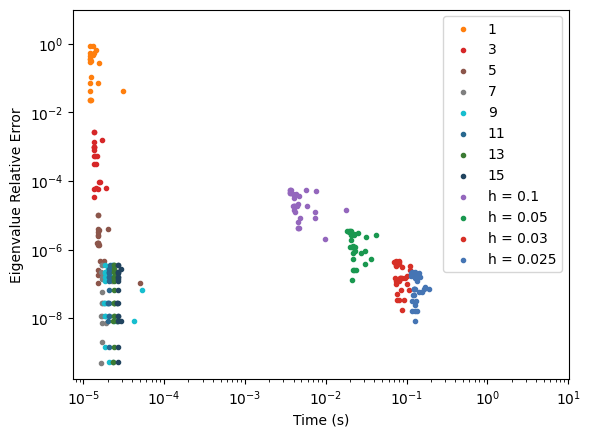

In [15]:
# We use the same h value as the high fidelity solution, but different alpha values
alphas = get_alphas("test")
h = 10**-1
errors = []
times = []
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
    "#c93a2a",
    "#28688f",
    "#5b165d",
    "#3b7b33",
    "#ad7a26",
    "#21445f",
    "#9c5f7c",
]
catFig, catAx = plt.subplots()
# We change the components and the alpha values for checking
for comp in range(1,17,2):
  times = []
  errors = []
  # Once again we only need the one instance of the RBM class for each component
  RBM_instance = RBM(h, m, comp)
  for alpha in alphas:
    # Instead of having a timing function, we do the timing calculation outside of the class
    timeDif = 0
    for i in range(10):
      time1 = time.time()
      evals, evects = RBM_instance.RBM_solve(alpha)
      time2 = time.time()
      timeDif += (time2 -time1)
    timeDif /= 10
    value = evals[0]
    # To provide an accurate comparison we use the exact analytical solution
    errorDif = abs(getExactLambda(alpha)-value)

    times.append(timeDif)
    errors.append(errorDif)
  color = colors[comp]
  catAx.scatter(times,errors,color=color,
            marker='.', label = str(comp))

maxT = hmaxT + 10
minT = hminT - 10
maxEr = max(errors) + 10
minEr = min(errors) - 10

hcolors = [
    "#9467bd",  # Purple
    "#1a9850",  # Emerald Green
    "#d73027",  # Crimson Red
    "#4575b4",  # Steel Blue
    "#fdae61",  # Apricot
    "#313695"   # Midnight Blue
]


for i in range(len(h_list)):
    label = "h = " + str(h_list[i])
    catAx.scatter(htimes[i],herrors[i],color=hcolors[i],
               marker='.',label=label)

catAx.set(xscale='log',yscale='log',
           xlabel='Time (s)',ylabel='Eigenvalue Relative Error',
           xlim=(hminT, hmaxT),ylim=(hminEr,hmaxEr))

plt.legend()
plt.show()
